In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/My Drive/data'

Mounted at /content/drive
/content/drive/My Drive/data


### Import all dependencies

In [2]:
from builtins import range, input

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten, AveragePooling2D, Dropout, MaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, roc_curve
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import cv2
from glob import glob

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.utils import to_categorical

### Define Few Parameters

In [3]:
path1 = 'ct/CT_COVID'
path2 = 'ct/CT_NonCOVID'

covid_positive_files = glob(path1 + '/*')
covid_negative_files = glob(path2 + '/*')

In [4]:
# Visualize file variable contents
print("First 5 Covid Files: ",covid_positive_files[0:5])
print("Total Count: ",len(covid_positive_files))
print("First 5 NonCovid Files: ",covid_negative_files[0:5])
print("Total Count: ",len(covid_negative_files))

First 5 Covid Files:  ['ct/CT_COVID/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89_1.png', 'ct/CT_COVID/2020.01.24.919183-p27-135.png', 'ct/CT_COVID/2020.02.10.20021584-p6-52_0.png', 'ct/CT_COVID/2020.02.10.20021584-p6-52_1.png', 'ct/CT_COVID/2020.01.24.919183-p27-132.png']
Total Count:  346
First 5 NonCovid Files:  ['ct/CT_NonCOVID/1061.png', 'ct/CT_NonCOVID/103.png', 'ct/CT_NonCOVID/1048.png', 'ct/CT_NonCOVID/1058.png', 'ct/CT_NonCOVID/1070.png']
Total Count:  397


In [8]:
# Fetch Images and Class Labels from Files
covid_labels = []
noncovid_labels = []

covid_positive_images=[]
covid_negative_images=[]

for i in range(len(covid_positive_files)):
  image = cv2.imread(covid_positive_files[i]) # read file 
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # arrange format as per keras
  image = cv2.resize(image,(224,224)) # resize as per model
  covid_positive_images.append(image) # append image
  covid_labels.append('CT_COVID') #append class label
for i in range(len(covid_negative_files)):
  image = cv2.imread(covid_negative_files[i])
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image,(224,224))
  covid_negative_images.append(image)
  noncovid_labels.append('CT_NonCOVID')

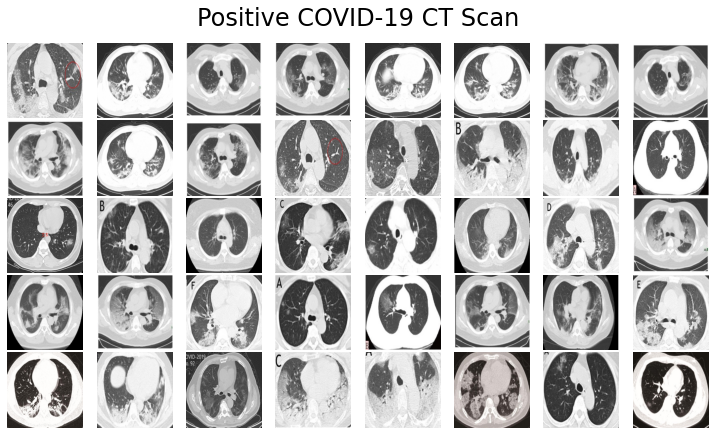

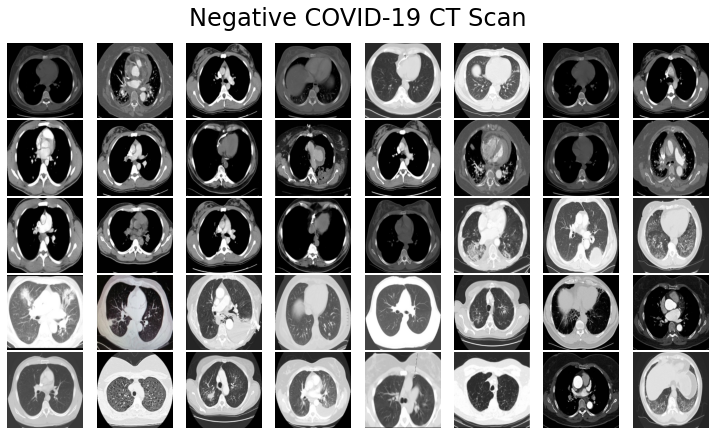

In [9]:
# look at a random image for fun
def plot_images(images, title):
    nrows, ncols = 5, 8
    figsize = [10, 6]

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, facecolor=(1, 1, 1))

    for i, axi in enumerate(ax.flat):
        axi.imshow(images[i])
        axi.set_axis_off()

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(pad=0.2, rect=[0, 0, 1, 0.9])
    plt.show()
plot_images(covid_positive_images, 'Positive COVID-19 CT Scan')
plot_images(covid_negative_images, 'Negative COVID-19 CT Scan')

In [ ]:
covid_positive_images = np.array(covid_positive_images) / 255
covid_negative_images = np.array(covid_negative_images) / 255

In [ ]:
covid_x_train, covid_x_test, covid_y_train, covid_y_test = train_test_split(
    covid_positive_images, covid_labels, test_size=0.2)
noncovid_x_train, noncovid_x_test, noncovid_y_train, noncovid_y_test = train_test_split(
    covid_negative_images, noncovid_labels, test_size=0.2)

X_train = np.concatenate((noncovid_x_train, covid_x_train), axis=0)
X_test = np.concatenate((noncovid_x_test, covid_x_test), axis=0)
y_train = np.concatenate((noncovid_y_train, covid_y_train), axis=0)
y_test = np.concatenate((noncovid_y_test, covid_y_test), axis=0)

y_train = LabelBinarizer().fit_transform(y_train)
y_train = to_categorical(y_train)

y_test = LabelBinarizer().fit_transform(y_test)
y_test = to_categorical(y_test)

### Visualize a few images from Training and Test sets

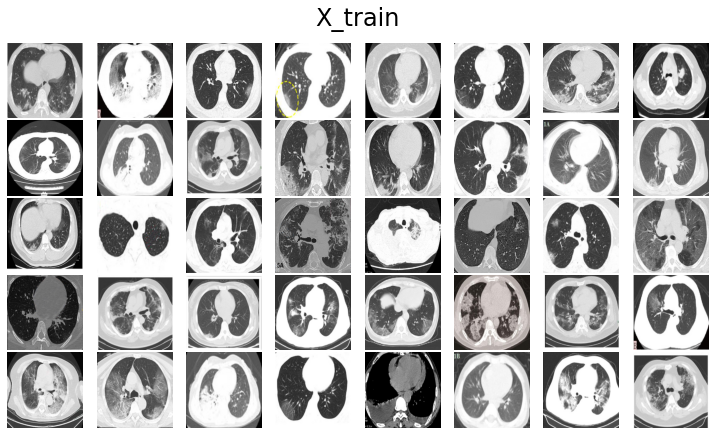

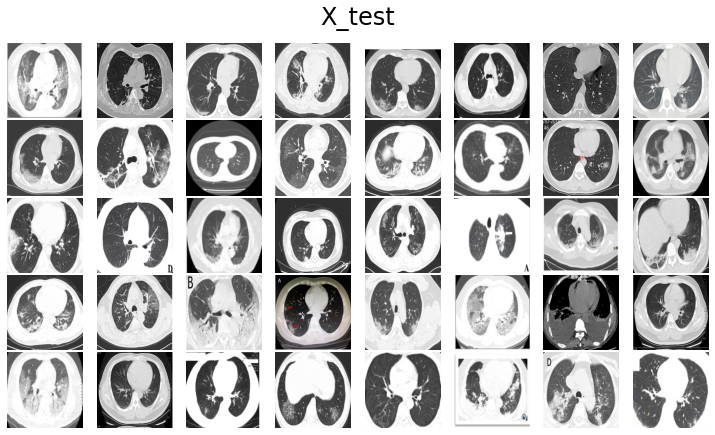

In [ ]:
plot_images(covid_x_train, 'X_train')
plot_images(covid_x_test, 'X_test')
# y_train and y_test contain class lables 0 and 1 representing COVID and NonCOVID for X_train and X_test

### **Building and Visualizing model**

In [ ]:
# Building Model
res = ResNet50(weights="imagenet", include_top=False,
    input_tensor=Input(shape=(224, 224, 3)))
last_layer = res.output
# last_layer = Flatten(name="flatten")(last_layer)
last_layer = MaxPooling2D()(last_layer)
last_layer = Flatten(name="flatten")(last_layer)
last_layer = Dropout(0.6)(last_layer)
last_layer = Dense(1024, activation="relu")(last_layer)
# last_layer = Dense(512,activation="relu")(last_layer)
last_layer = Dense(2, activation="softmax")(last_layer)

# outputs = resnet.output
# outputs = Flatten(name="flatten")(outputs)
# outputs = Dropout(0.5)(outputs)
# outputs = Dense(2, activation="softmax")(outputs)

model = Model(inputs=res.input, outputs=last_layer)

# for layer in resnet.layers:
#     layer.trainable = False

model.compile(
        loss='categorical_crossentropy', 
        optimizer='adam', 
        metrics=['accuracy']
)

In [ ]:
# Visualize Model
model.summary()

Model: "functional_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
_______________________________________________________________________________________

### **Image Augmentation**
#### To train on images at different positions, angles, flips, etc

In [ ]:
train_aug = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

### **Training the model**

In [ ]:
history = model.fit(train_aug.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    validation_steps=len(X_test) / 32,
                    steps_per_epoch=len(X_train) / 32,
                    epochs=50)

Epoch 1/50
19/18 [==============================] - 7s 394ms/step - loss: 11.6577 - accuracy: 0.5312 - val_loss: 10163.8496 - val_accuracy: 0.5333
Epoch 2/50
19/18 [==============================] - 6s 335ms/step - loss: 0.6664 - accuracy: 0.6425 - val_loss: 325.1755 - val_accuracy: 0.5333
Epoch 3/50
19/18 [==============================] - 6s 336ms/step - loss: 0.6733 - accuracy: 0.6341 - val_loss: 4.0351 - val_accuracy: 0.5333
Epoch 4/50
19/18 [==============================] - 6s 339ms/step - loss: 0.6446 - accuracy: 0.6695 - val_loss: 0.6945 - val_accuracy: 0.5467
Epoch 5/50
19/18 [==============================] - 6s 340ms/step - loss: 0.6673 - accuracy: 0.6897 - val_loss: 1.7727 - val_accuracy: 0.4667
Epoch 6/50
19/18 [==============================] - 6s 338ms/step - loss: 0.6240 - accuracy: 0.6897 - val_loss: 0.7730 - val_accuracy: 0.4667
Epoch 7/50
19/18 [==============================] - 6s 336ms/step - loss: 0.6605 - accuracy: 0.6374 - val_loss: 0.6934 - val_accuracy: 0.4600

In [ ]:
%cd '/content/drive/My Drive/model'

/content/drive/My Drive/model


In [ ]:
model.save("")

INFO:tensorflow:Assets written to: ResNet50CT2/assets


In [ ]:
from tensorflow.keras.models import load_model
reloaded = load_model("ResNet50CT2")

In [ ]:
# Save Model and Weights
model.save('resnet_ct.h5')
model.save_weights('resnet_weights_ct.hdf5')

In [ ]:
from tensorflow.keras.models import load_model
model = load_model("ResNet50CT2")

In [ ]:
# Load saved model
model = load_model('resnet_ct.h5')

### **Making Predicions**

In [ ]:
y_pred = model.predict(X_test, batch_size=32)

### Visulaizing First 10 predictions

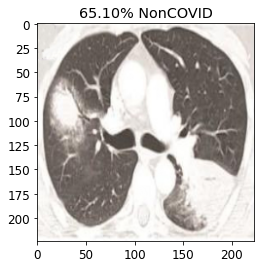

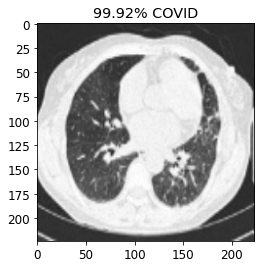

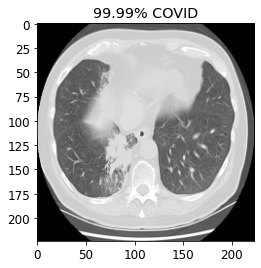

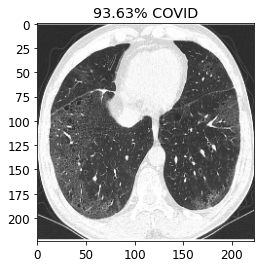

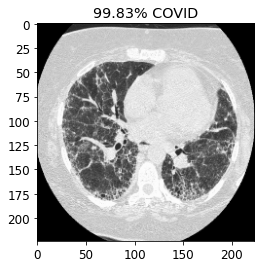

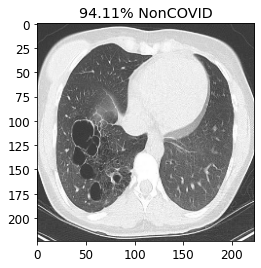

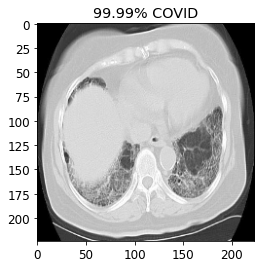

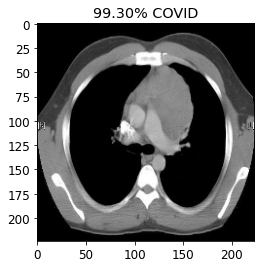

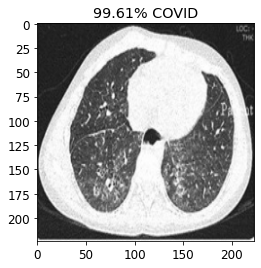

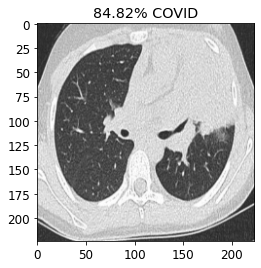

In [ ]:
prediction=y_pred[0:10]
for index, probability in enumerate(prediction):
  if probability[1] > 0.5:
        plt.title('%.2f' % (probability[1]*100) + '% COVID')
  else:
        plt.title('%.2f' % ((1-probability[1])*100) + '% NonCOVID')
  plt.imshow(X_test[index])
  plt.show()

In [ ]:
# Convert to Binary classes
y_pred_bin = np.argmax(y_pred, axis=1)
y_test_bin = np.argmax(y_test, axis=1)

### Plot ROC Curve

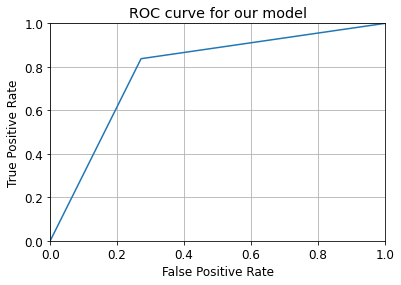

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_bin, y_pred_bin)
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for our model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

### Plot Confusion Matrix

Confusion Matrix without Normalization


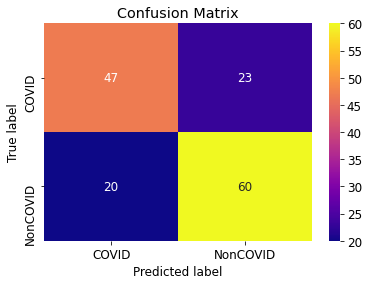

Confusion Matrix with Normalized Values


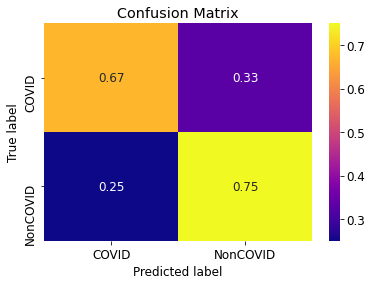

In [ ]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NonCOVID']
  tick_marks = [0.5,1.5]
  cn = confusion_matrix(y_test_bin, y_pred_bin,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)

print('Confusion Matrix with Normalized Values')
plot_confusion_matrix(normalize='true')

### **Classification Report**

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_bin,y_pred_bin))

              precision    recall  f1-score   support

           0       0.80      0.73      0.76        70
           1       0.78      0.84      0.81        80

    accuracy                           0.79       150
   macro avg       0.79      0.78      0.78       150
weighted avg       0.79      0.79      0.79       150



### **Accuracy and Loss Plots**

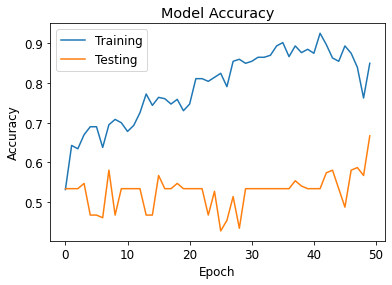

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_ct_accuracy.png')
plt.show()


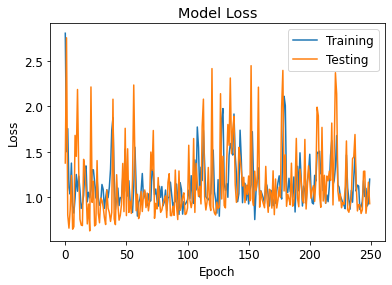

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('resnet_ct_loss.png')
plt.show()